**Import library**

In [1]:
!pip install pythainlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.6 MB 5.0 MB/s 


In [2]:
import tensorflow as tf
Model = tf.keras.models.Model
ModelCheckpoint = tf.keras.callbacks.ModelCheckpoint
ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau
load_model = tf.keras.models.load_model

from pythainlp.tokenize import word_tokenize, Tokenizer
KRTokenizer = tf.keras.preprocessing.text.Tokenizer

pad_sequences = tf.keras.preprocessing.sequence.pad_sequences
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd 

import nltk

# from nltk.corpus import wordnet as wn
# from nltk.corpus import sentiwordnet as swn
from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')
# nltk.download('sentiwordnet')
nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('omw-1.4')
# lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

from pythainlp.corpus.common import thai_words
from pythainlp.corpus import thai_stopwords

import seaborn as sn
import matplotlib.pyplot as plt

import pickle as p
import plotly
import plotly.graph_objs as go

from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report
from gensim.models import Word2Vec

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Define constant value for model**

In [3]:
EPOCHS = 15
BS = 32
DIMENSION = 100

**Read data from each dataset**

In [4]:
df_kplus = pd.read_csv('/content/KPlus_Googleplay.csv')
df_scb = pd.read_csv('/content/SCB_Easy_Googleplay_cut.csv')
df_ktb = pd.read_csv('/content/Krungthai_next_Googleplay.csv')

**Remove some column from Kplus dataset**

In [5]:
df_kplus.head(4)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,Class
0,9f20248d-8b73-408e-8e06-5556e5e342ad,นายมงคล เขียวบุญแย้ม,https://play-lh.googleusercontent.com/a/ALm5wu...,ชอบแอบนี้มากๆ5.5,5,0,NaN,2022-11-12 06:13:13,ขอขอบคุณ ที่ไว้วางใจใช้บริการ K PLUS ของธนาคาร...,2022-11-12 13:47:24,pos
1,864104fc-01d0-4a44-835d-f1ae41031bfd,Punpun aoorza Goodnow,https://play-lh.googleusercontent.com/a-/ACNPE...,ใช้มาตลอดพออัพเดทล่าสุดนี่เข้าไม่ได้เลยและเด้ง...,2,0,5.16.3,2022-11-12 06:07:28,ขออภัยในความไม่สะดวกที่ได้รับค่ะ เบื้องต้นรบกว...,2022-11-12 13:47:10,neg
2,8f8e9708-35aa-425d-b044-17acfa120fa2,PalmZer Ch,https://play-lh.googleusercontent.com/a-/ACNPE...,ช่วงนี้แอปชอบเปิดเอง ทั้งๆที่ไม่ได้ใช้ ขึ้นมาข...,3,0,5.16.3,2022-11-12 04:54:49,ขออภัยในความไม่สะดวกที่ได้รับนะคะ หากพบปัญหากา...,2022-11-12 16:28:57,neg
3,1225a715-8ad3-4093-90b8-71b3eeaeb7c7,ปรินทร์พร ทิพย์สุวรรณ,https://play-lh.googleusercontent.com/a-/ACNPE...,ช่วงนี้แอฟเด้งมาบ่อยเลยค่ะ ในขณะที่ใช้แอฟอื่นอ...,2,0,5.16.3,2022-11-12 04:39:23,ขออภัยในความไม่สะดวกที่ได้รับนะคะ เบื้องต้นรบก...,2022-11-12 16:28:47,neg


In [6]:
df_kplus.rename(columns = {'at':'timestamp', 'Class':'class'}, inplace = True)
kplus_remove_columns = ['reviewId', 'userName','userImage','replyContent','repliedAt']
df_kplus.drop(kplus_remove_columns, axis=1, inplace=True)

In [7]:
df_kplus.columns

Index(['content', 'score', 'thumbsUpCount', 'reviewCreatedVersion',
       'timestamp', 'class'],
      dtype='object')

**Remove some column from SCB dataset**

In [8]:
df_scb.head(4)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,Score
0,bb808b6e-7b5f-4708-9cf0-cce451e6b78b,ใหม ใหม่,https://play-lh.googleusercontent.com/a-/ACNPE...,ขยันอัปเดตจัง แต่!!ไม่มีอะไรดีขึ้นเลย,1.0,0.0,3.56.0,2022-11-12 14:47:24,NaN,NaN,neg
1,00475d91-ada3-4416-b84d-6e66c8b18f2b,ความลับในใจ,https://play-lh.googleusercontent.com/a-/ACNPE...,เยี่ยม,5.0,0.0,3.56.0,2022-11-12 13:38:43,NaN,NaN,neg
2,11a3b575-57a5-4922-98b7-1d1e85c27a57,นางสาวชนานุช ดอกประทุม,https://play-lh.googleusercontent.com/a/ALm5wu...,ไม่สามารถโหลดเพื่ออัพเดทแอปได้เมมเต็ม,5.0,0.0,3.56.0,2022-11-12 13:06:09,NaN,NaN,neg
3,cf0553f1-6bcf-499f-82e3-13757311f66e,SuKuRuLo KoHeJiNaTo,https://play-lh.googleusercontent.com/a/ALm5wu...,แอปเป็นอะไรวะทำไทถึงเข้าไม่ได้อ่า แก้ไขหน่อยนะ,1.0,0.0,3.56.0,2022-11-12 13:05:33,NaN,NaN,neg


In [9]:
df_scb.rename(columns = {'at':'timestamp', 'Score':'class'}, inplace = True)
scb_remove_columns = ['reviewId', 'userName','userImage','replyContent','repliedAt']
df_scb.drop(kplus_remove_columns, axis=1, inplace=True)

In [10]:
df_scb.columns

Index(['content', 'score', 'thumbsUpCount', 'reviewCreatedVersion',
       'timestamp', 'class'],
      dtype='object')

**Remove some column from KTB dataset**

In [11]:
df_ktb.head(4)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,Time Stamp,Label,Unnamed: 9
0,bdfd375a-701e-4bc4-a5ff-ac1405a4f063,สุริยา ณ.สมุทร,https://play-lh.googleusercontent.com/a-/ACNPE...,ดี,5,0,11.9.1,2022-11-12 07:17:54,pos,NaN
1,9181b9cf-bc01-4b90-bc65-aa67ae5ebb81,Jumlean Luecha,https://play-lh.googleusercontent.com/a/ALm5wu...,Good,5,0,11.9.1,2022-11-12 06:53:18,pos,NaN
2,f14a5783-0f0f-4c1c-b9d4-7ea0d78f52cf,SAMLEE TRUDMAKKA,https://play-lh.googleusercontent.com/a/ALm5wu...,ให้บริการดีขอบคุณมากค่ะ,5,0,11.9.1,2022-11-12 06:50:52,pos,NaN
3,3ad1db88-f0c1-4e0f-8853-92352f070acc,มาหามะรอมือลี เห็ง,https://play-lh.googleusercontent.com/a/ALm5wu...,รุ่.,4,0,11.6.3,2022-11-12 06:27:40,?,NaN


In [12]:
df_ktb.rename(columns = {'Time Stamp':'timestamp', 'Label':'class'}, inplace = True)
ktb_remove_columns = ['reviewId', 'userName','userImage','Unnamed: 9']
df_ktb.drop(ktb_remove_columns, axis=1, inplace=True)

In [13]:
df_ktb.columns

Index(['content', 'score', 'thumbsUpCount', 'reviewCreatedVersion',
       'timestamp', 'class'],
      dtype='object')

**Merged dataset into dataframe**

In [14]:
df = pd.concat([df_kplus, df_scb, df_ktb], ignore_index=True, sort=False)

In [15]:
df.head()

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class
0,ชอบแอบนี้มากๆ5.5,5.0,0.0,NaN,2022-11-12 06:13:13,pos
1,ใช้มาตลอดพออัพเดทล่าสุดนี่เข้าไม่ได้เลยและเด้ง...,2.0,0.0,5.16.3,2022-11-12 06:07:28,neg
2,ช่วงนี้แอปชอบเปิดเอง ทั้งๆที่ไม่ได้ใช้ ขึ้นมาข...,3.0,0.0,5.16.3,2022-11-12 04:54:49,neg
3,ช่วงนี้แอฟเด้งมาบ่อยเลยค่ะ ในขณะที่ใช้แอฟอื่นอ...,2.0,0.0,5.16.3,2022-11-12 04:39:23,neg
4,ดี,5.0,0.0,5.16.3,2022-11-12 04:34:57,pos


**Check data type**

In [16]:
df.dtypes

content                  object
score                   float64
thumbsUpCount           float64
reviewCreatedVersion     object
timestamp                object
class                    object
dtype: object

**Check null value and clean column**

In [17]:
df.isnull().sum()

content                   1
score                     1
thumbsUpCount             1
reviewCreatedVersion    751
timestamp                 1
class                     8
dtype: int64

In [18]:
df['content'] = df['content'].astype('str') 
df['content'] = df['content'].replace(np.nan,"")

In [19]:
df['score'] = df['score'].replace(np.nan,0)

In [20]:
df['thumbsUpCount'] = df['thumbsUpCount'].replace(np.nan,0)

In [21]:
df['reviewCreatedVersion'] = df['reviewCreatedVersion'].astype('str') 
df['reviewCreatedVersion'] = df['reviewCreatedVersion'].replace("nan","0.0.0")
df['reviewCreatedVersion'] = df['reviewCreatedVersion'].replace("","0.0.0")

In [22]:
df['timestamp'] = df['timestamp'].astype('str') 
df['timestamp'] = df['timestamp'].replace(np.nan,"")

In [23]:
df['class'].value_counts()

pos    1800
neg    1522
?       214
xxx       6
Name: class, dtype: int64

In [24]:
df['class'] = df['class'].astype('str') 
df['class'] = df['class'].replace("nan","?")
df['class'] = df['class'].replace("xxx","?")

In [25]:
df['class'].value_counts()

pos    1800
neg    1522
?       228
Name: class, dtype: int64

In [26]:
df.isnull().sum()

content                 0
score                   0
thumbsUpCount           0
reviewCreatedVersion    0
timestamp               0
class                   0
dtype: int64

**From above class value count**

* We should sample class with equal row number. (pos=1522, neg=1522)
* For alternative class("?"), predict in next model

In [27]:
pos_df = df[df['class'] == "pos"].sample(1522, random_state = 42)
pos_df

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class
3110,ถูกใจ,5.0,0.0,11.9.1,2022-10-25 07:29:15,pos
1756,ใช้ด้ดีมากๆ,5.0,0.0,3.60.0,2022-10-31 06:56:03,pos
1641,สดวกใช้ง่าย,5.0,0.0,3.60.0,2022-11-04 19:25:52,pos
293,ดี,5.0,0.0,5.16.1,2022-11-06 18:19:54,pos
2335,ฉันชอบมากทุกวัน❤️❤️❤️,5.0,1.0,3.59.0,2022-10-07 05:03:46,pos
...,...,...,...,...,...,...
3516,ขอบคุณครับ,5.0,0.0,11.9.1,2022-10-11 10:17:21,pos
3339,ใช้แล้วดี,3.0,0.0,11.8.1,2022-10-18 12:54:47,pos
1017,ยอดเยี่ยมชอบมาก,5.0,0.0,5.16.1,2022-10-22 10:45:54,pos
1731,ดีมาก,5.0,0.0,3.60.0,2022-10-31 22:57:43,pos


In [28]:
neg_df = df[df['class'] == "neg"].sample(1522, random_state = 42)
neg_df

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class
1347,พอจะรีบใช้งาน มีปัญหาทุกครั้ง,1.0,0.0,5.16.1,2022-10-16 10:02:21,neg
2536,อัปเดตแทนที่แอพพลิเคชันจะดีกว่าเดิมแต่ยิ่งอัปเ...,1.0,7.0,3.59.0,2022-09-30 07:32:45,neg
3366,ทำมัยเบอร์ต้องตรงเวลาสำคัญทำไม่ได้เลยแย่มากๆ,1.0,0.0,11.9.1,2022-10-17 14:05:44,neg
2770,มีปัญหาอยู่อย่างหนึ่งและก้เปนอยู่บ่อยๆ..เวลาโอ...,3.0,6.0,11.9.1,2022-11-03 03:47:13,neg
2411,อยู่ดีๆแอปก้อล็อคเองเฉย 😒😒,2.0,0.0,0.0.0,2022-10-04 11:40:20,neg
...,...,...,...,...,...,...
2595,ห่วยแตกโอนเงินไม่เข้า,1.0,0.0,0.0.0,2022-11-11 00:28:13,neg
3043,สิ้นเดือนมีปัญหาตลอด ทำไมไม่เคยหาทางแก้ไขเนี่ย...,1.0,0.0,11.9.1,2022-10-25 08:52:53,neg
2143,และ app เป็นไรชอบล่มตอน 23:00 น กับเที่ยงคืนแล...,1.0,0.0,0.0.0,2022-10-12 18:49:26,neg
3329,แย่ชิปหาย ปรุงเถอะ เวลาเปลี่ยนเครื่องยังต้องแส...,1.0,6.0,11.9.1,2022-10-19 01:49:12,neg


In [29]:
unknown_df = df[df['class'] == "?"]
unknown_df

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class
84,CC6844421,5.0,0.0,5.16.3,2022-11-10 18:04:18,?
94,ิอิอิ,5.0,0.0,5.16.3,2022-11-10 14:18:38,?
144,i ij!!,3.0,0.0,5.16.1,2022-11-09 19:25:31,?
147,ดี,4.0,0.0,0.0.0,2022-11-09 15:16:32,?
164,~ช,5.0,0.0,5.16.1,2022-11-09 10:29:10,?
...,...,...,...,...,...,...
3524,กู้เงินสินเชื่อ,4.0,0.0,0.0.0,2022-10-11 05:17:39,?
3526,ลองใช้ก่อน,1.0,0.0,0.0.0,2022-10-11 04:44:04,?
3527,11/10/22 09:00-09:46เข้าแอพไม่ได้ครับ,3.0,0.0,11.5.5,2022-10-11 02:46:25,?
3541,ตคคตจ,4.0,0.0,11.9.1,2022-10-10 09:51:25,?


**Text PreProcessing**
*   Change Case
*   Removing Punctuations
*   Change Custom Words
*   Tokenization
*   Removing Stop Words
*   Change Correct Words


In [30]:
sentiment_df = pd.concat([neg_df, pos_df])
sentiment_df

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class
1347,พอจะรีบใช้งาน มีปัญหาทุกครั้ง,1.0,0.0,5.16.1,2022-10-16 10:02:21,neg
2536,อัปเดตแทนที่แอพพลิเคชันจะดีกว่าเดิมแต่ยิ่งอัปเ...,1.0,7.0,3.59.0,2022-09-30 07:32:45,neg
3366,ทำมัยเบอร์ต้องตรงเวลาสำคัญทำไม่ได้เลยแย่มากๆ,1.0,0.0,11.9.1,2022-10-17 14:05:44,neg
2770,มีปัญหาอยู่อย่างหนึ่งและก้เปนอยู่บ่อยๆ..เวลาโอ...,3.0,6.0,11.9.1,2022-11-03 03:47:13,neg
2411,อยู่ดีๆแอปก้อล็อคเองเฉย 😒😒,2.0,0.0,0.0.0,2022-10-04 11:40:20,neg
...,...,...,...,...,...,...
3516,ขอบคุณครับ,5.0,0.0,11.9.1,2022-10-11 10:17:21,pos
3339,ใช้แล้วดี,3.0,0.0,11.8.1,2022-10-18 12:54:47,pos
1017,ยอดเยี่ยมชอบมาก,5.0,0.0,5.16.1,2022-10-22 10:45:54,pos
1731,ดีมาก,5.0,0.0,3.60.0,2022-10-31 22:57:43,pos


Change Case

In [31]:
sentiment_df['clean_comments'] = sentiment_df['content'].fillna('').apply(lambda x: x.lower())
sentiment_df.head()

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class,clean_comments
1347,พอจะรีบใช้งาน มีปัญหาทุกครั้ง,1.0,0.0,5.16.1,2022-10-16 10:02:21,neg,พอจะรีบใช้งาน มีปัญหาทุกครั้ง
2536,อัปเดตแทนที่แอพพลิเคชันจะดีกว่าเดิมแต่ยิ่งอัปเ...,1.0,7.0,3.59.0,2022-09-30 07:32:45,neg,อัปเดตแทนที่แอพพลิเคชันจะดีกว่าเดิมแต่ยิ่งอัปเ...
3366,ทำมัยเบอร์ต้องตรงเวลาสำคัญทำไม่ได้เลยแย่มากๆ,1.0,0.0,11.9.1,2022-10-17 14:05:44,neg,ทำมัยเบอร์ต้องตรงเวลาสำคัญทำไม่ได้เลยแย่มากๆ
2770,มีปัญหาอยู่อย่างหนึ่งและก้เปนอยู่บ่อยๆ..เวลาโอ...,3.0,6.0,11.9.1,2022-11-03 03:47:13,neg,มีปัญหาอยู่อย่างหนึ่งและก้เปนอยู่บ่อยๆ..เวลาโอ...
2411,อยู่ดีๆแอปก้อล็อคเองเฉย 😒😒,2.0,0.0,0.0.0,2022-10-04 11:40:20,neg,อยู่ดีๆแอปก้อล็อคเองเฉย 😒😒


Removing Punctuations

In [32]:
pun = '"#\'()*,-.;<=>[\\]^_`{|}~'
pun

'"#\'()*,-.;<=>[\\]^_`{|}~'

In [33]:
sentiment_df['clean_comments'] = sentiment_df['clean_comments'].str.replace(r'[%s]' % (pun), '', regex=True)
sentiment_df.sample(5)

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class,clean_comments
3077,Error บ่อยมากกกกก พัฒนาระบบให้ดีก่อนนะ,1.0,1.0,11.9.1,2022-10-25 08:05:17,neg,error บ่อยมากกกกก พัฒนาระบบให้ดีก่อนนะ
1448,ใช้แอฟกสิกรยุแต่พอเปลี่ยนเครื่องโทสับใหม่ทำใมใ...,1.0,0.0,0.0.0,2022-10-14 02:25:22,neg,ใช้แอฟกสิกรยุแต่พอเปลี่ยนเครื่องโทสับใหม่ทำใมใ...
1730,แม่งก็ใช้ไม่ได้ บ่อย เกิน,2.0,0.0,3.60.0,2022-11-01 00:33:01,neg,แม่งก็ใช้ไม่ได้ บ่อย เกิน
2864,ธนาคารมีปัญหาโคตรบ่อย เดี๋ยวใช้ได้ใช้ไม่ได้อยู...,1.0,0.0,11.9.1,2022-10-31 03:05:30,neg,ธนาคารมีปัญหาโคตรบ่อย เดี๋ยวใช้ได้ใช้ไม่ได้อยู...
755,ดีคราบเเปนมันอะไรก็มัยรู้นะคราบ ก็เลยสงไปก้อนนะ,5.0,1.0,5.16.0,2022-10-29 09:31:51,pos,ดีคราบเเปนมันอะไรก็มัยรู้นะคราบ ก็เลยสงไปก้อนนะ


Custom word

In [34]:
THAI_CUSTOM_WORDS = '/content/thai_custom_words2.txt'
THAI_CORRECT_WORDS = '/content/thai_correct_words.txt'

In [36]:
with open(THAI_CUSTOM_WORDS, encoding='utf8') as f:
    words = [line.strip() for line in f]

words

['เคแบง',
 'เคแบงก์',
 'Kplus',
 'กรุงไทย',
 'เคพลัส',
 'เคพัส',
 'K PLUS',
 'KPLUS',
 'k plus',
 'SCB',
 'ไทยพานิต',
 'คิวอาร์โค้ด',
 'กสิกรไทย',
 'คิวอาร์',
 'รีบูต',
 'ดีเลย์',
 'แอปพลิเคชัน',
 'แอป',
 'แอบ',
 'แอ๊ป',
 'แอฟ',
 'แอ้ป',
 'แอบ',
 'แอพ',
 'แอพปริชั่น',
 'เธ๊ออออ',
 'สดวก',
 'ก้อ',
 'ใด้',
 'จังกวะ',
 'หร้า',
 'เปยี่ยน',
 'เป้น',
 'บันชี',
 'บัชชี',
 'โคต',
 'โครต',
 'ไห้',
 'อารมย์',
 'สะดววก',
 'ธนาคาน',
 'รำคาน',
 'สามรถ',
 'คัฟ',
 'อัพเดต',
 'อัพเดท',
 'อัพเดท',
 'อัปเดท',
 'อัทเดท',
 'ครัย',
 'เรย',
 'งา่ย',
 'จัย',
 'ระหัส',
 'มรึง',
 'ธนาคาา',
 'ธนคาร',
 'บรืการ']

In [37]:
custom_words_list = set(thai_words())
len(custom_words_list)

62055

In [38]:
custom_words_list.update(words)
len(custom_words_list)

62099

Tokenization

In [39]:
custom_tokenizer = Tokenizer(custom_words_list)

In [40]:
sentiment_df['clean_comments'] = sentiment_df['clean_comments'].apply(lambda x: custom_tokenizer.word_tokenize(x))

In [41]:
sentiment_df.sample(5)

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class,clean_comments
2283,แอปล่มบ่อยมาก อืดๆยังไงไม่รู้ช่วงนี้,3.0,0.0,3.59.0,2022-10-08 03:15:13,neg,"[แอป, ล่ม, บ่อย, มาก, , อืด, ๆ, ยังไง, ไม่, ร..."
3342,ไม่มีปุ่มกดลืมรหัสPIN,3.0,0.0,11.9.1,2022-10-18 08:22:31,neg,"[ไม่, มี, ปุ่มกด, ลืม, รหัส, pin]"
1206,สะดวก สะบาย,5.0,0.0,5.16.1,2022-10-18 12:46:09,pos,"[สะดวก, , สะ, บาย]"
98,ช่วงนี้แอพเด้งตลอดเลย แล้วบอกให้อัพเกรด พอกดจะ...,3.0,0.0,5.16.3,2022-11-10 13:50:13,neg,"[ช่วงนี้, แอพ, เด้ง, ตลอด, เลย, , แล้ว, บอก, ..."
250,Ok,5.0,1.0,0.0.0,2022-11-07 14:56:10,pos,[ok]


In [42]:
tokenized_doc = sentiment_df['clean_comments']
tokenized_doc[:10]

1347          [พอ, จะ, รีบ, ใช้งาน,  , มีปัญหา, ทุกครั้ง]
2536    [อัปเดต, แทนที่, แอพพลิเคชัน, จะ, ดีกว่า, เดิม...
3366    [ทำ, มัย, เบอร์, ต้อง, ตรงเวลา, สำคัญ, ทำ, ไม่...
2770    [มีปัญหา, อยู่, อย่างหนึ่ง, และ, ก้เปน, อยู่, ...
2411           [อยู่ดีๆ, แอป, ก้อ, ล็อค, เอง, เฉย,  , 😒😒]
1054    [ใช้, ยุ่งยาก, ชิบหาย,  , บาง, คนใช้, รายเดือน...
2134    [ทำไม, ต้อง, ติดต่อ, ธนาคาร, ครับ, เข้าไป, แล้...
3440                                [ระบบ, ช้า, มาก, ค่ะ]
2447    [แอป, มี, ปัญญา, หา, อะไร, หนักหนา, ครับ, ล่ม,...
2514    [จำได้, ว่า, เคย, ให้คะแนน, แอป, ดีมาก,  , แต่...
Name: clean_comments, dtype: object

Delete english stop word

In [43]:
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

In [44]:
tokenized_doc[:10]

1347          [พอ, จะ, รีบ, ใช้งาน,  , มีปัญหา, ทุกครั้ง]
2536    [อัปเดต, แทนที่, แอพพลิเคชัน, จะ, ดีกว่า, เดิม...
3366    [ทำ, มัย, เบอร์, ต้อง, ตรงเวลา, สำคัญ, ทำ, ไม่...
2770    [มีปัญหา, อยู่, อย่างหนึ่ง, และ, ก้เปน, อยู่, ...
2411           [อยู่ดีๆ, แอป, ก้อ, ล็อค, เอง, เฉย,  , 😒😒]
1054    [ใช้, ยุ่งยาก, ชิบหาย,  , บาง, คนใช้, รายเดือน...
2134    [ทำไม, ต้อง, ติดต่อ, ธนาคาร, ครับ, เข้าไป, แล้...
3440                                [ระบบ, ช้า, มาก, ค่ะ]
2447    [แอป, มี, ปัญญา, หา, อะไร, หนักหนา, ครับ, ล่ม,...
2514    [จำได้, ว่า, เคย, ให้คะแนน, แอป, ดีมาก,  , แต่...
Name: clean_comments, dtype: object

Delete thai stop word

In [45]:
th_stop_words = list(thai_stopwords())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in th_stop_words])

In [46]:
tokenized_doc[:10]

1347                            [รีบ, ใช้งาน,  , มีปัญหา]
2536    [อัปเดต, แทนที่, แอพพลิเคชัน, ดีกว่า, เดิม, อั...
3366                [ทำ, มัย, เบอร์, ตรงเวลา, ทำ, แย่มาก]
2770    [มีปัญหา, ก้เปน, เวลา, โอน, เสด, สลิป, ภาพ, หา...
2411                     [อยู่ดีๆ, แอป, ก้อ, ล็อค,  , 😒😒]
1054    [ยุ่งยาก, ชิบหาย,  , คนใช้, รายเดือน,  , เติม,...
2134     [ติดต่อ, ธนาคาร, เข้าไป, แล้วก็, ติดต่อ, ธนาคาร]
3440                                               [ระบบ]
2447    [แอป, ปัญญา, หา, หนักหนา, ล่ม, หยุด, จ่าย, ลูก...
2514    [จำได้, ให้คะแนน, แอป, ดีมาก,  , ตอนนี้, ติดลบ...
Name: clean_comments, dtype: object

Correct Word

In [47]:
with open(THAI_CORRECT_WORDS) as f:
    thai_correct_word_list = [line.strip() for line in f]
    
thai_correct_word_list

['แอป แอปพลิเคชัน',
 'แอบ แอปพลิเคชัน',
 'แอ๊ป แอปพลิเคชัน',
 'แอฟ แอปพลิเคชัน',
 'แอ้ป แอปพลิเคชัน',
 'แอบ แอปพลิเคชัน',
 'แอพ แอปพลิเคชัน',
 'แอพปริชั่น แอปพลิเคชัน',
 'เธ๊ออออ เธอ',
 'สดวก สะดวก',
 'ก้อ ก็',
 'ใด้ ได้',
 'จังกวะ จังหวะ',
 'หร้า หน้า',
 'เปยี่ยน เปลี่ยน',
 'เป้น เป็น',
 'บันชี บัญชี',
 'บัชชี บัญชี',
 'โคต โคตร',
 'โครต โคตร',
 'ไห้ ให้',
 'อารมย์ อารมณ์',
 'สะดววก สะดวก',
 'ธนาคาน ธนาคาร',
 'รำคาน รำคาญ',
 'สามรถ สามารถ',
 'คัฟ ครับ',
 'อัพเดต อัปเดต',
 'อัพเดท อัปเดต',
 'อัพเดท อัปเดต',
 'อัปเดท อัปเดต',
 'อัทเดท อัปเดต',
 'ครัย ครับ',
 'เรย เลย',
 'งา่ย ง่าย',
 'จัย ใจ',
 'ระหัส รหัส',
 'มรึง มึง',
 'ธนาคาา ธนาคาร',
 'ธนคาร ธนาคาร',
 'บรืการ บริการ']

In [48]:
correct_pair={}

for pair in thai_correct_word_list:
    correct_pair[pair.split()[0].strip()]=pair.split()[1].strip() 

In [49]:
doc = []
for tokenized_list in tokenized_doc:
    for index, word in enumerate(tokenized_list):
        if word in correct_pair:
            tokenized_list[index]=correct_pair[word]
    doc.append(tokenized_list)
    
tokenized_doc = pd.Series(doc)

In [50]:
tokenized_doc

0                               [รีบ, ใช้งาน,  , มีปัญหา]
1       [อัปเดต, แทนที่, แอพพลิเคชัน, ดีกว่า, เดิม, อั...
2                   [ทำ, มัย, เบอร์, ตรงเวลา, ทำ, แย่มาก]
3       [มีปัญหา, ก้เปน, เวลา, โอน, เสด, สลิป, ภาพ, หา...
4                 [อยู่ดีๆ, แอปพลิเคชัน, ก็, ล็อค,  , 😒😒]
                              ...                        
3039                                             [ขอบคุณ]
3040                                        [ใช้แล้ว, ดี]
3041                                     [ยอดเยี่ยม, ชอบ]
3042                                              [ดีมาก]
3043                                                 [ดี]
Length: 3044, dtype: object

In [51]:
tokenized_doc = tokenized_doc.to_list()

De-tokenization

In [52]:
# de-tokenization
detokenized_doc = []
for i in range(len(tokenized_doc)):
#     print(tokenized_doc[i])
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)
    
sentiment_df['clean_comments'] = detokenized_doc

In [53]:
sentiment_df.head()

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class,clean_comments
1347,พอจะรีบใช้งาน มีปัญหาทุกครั้ง,1.0,0.0,5.16.1,2022-10-16 10:02:21,neg,รีบ ใช้งาน มีปัญหา
2536,อัปเดตแทนที่แอพพลิเคชันจะดีกว่าเดิมแต่ยิ่งอัปเ...,1.0,7.0,3.59.0,2022-09-30 07:32:45,neg,อัปเดต แทนที่ แอพพลิเคชัน ดีกว่า เดิม อัปเดต แ...
3366,ทำมัยเบอร์ต้องตรงเวลาสำคัญทำไม่ได้เลยแย่มากๆ,1.0,0.0,11.9.1,2022-10-17 14:05:44,neg,ทำ มัย เบอร์ ตรงเวลา ทำ แย่มาก
2770,มีปัญหาอยู่อย่างหนึ่งและก้เปนอยู่บ่อยๆ..เวลาโอ...,3.0,6.0,11.9.1,2022-11-03 03:47:13,neg,มีปัญหา ก้เปน เวลา โอน เสด สลิป ภาพ หาย ภาพ คร...
2411,อยู่ดีๆแอปก้อล็อคเองเฉย 😒😒,2.0,0.0,0.0.0,2022-10-04 11:40:20,neg,อยู่ดีๆ แอปพลิเคชัน ก็ ล็อค 😒😒


Split test data

In [54]:
temp_df = sentiment_df

sentiment_df = temp_df.sample(2435, random_state = 42)
test_df = temp_df.sample(609, random_state = 42) #total 3044 rows, train 609 rows, test 2435 rows

In [55]:
cleaned_words = sentiment_df['clean_comments'].to_list()

In [56]:
cleaned_words[:1]

['สแกน ใบหน้า ดี ระบบ ปรับปรุง']

**Tokenization with keras (use vector result from keras)**

In [57]:
def create_tokenizer(words, filters = ''):
    token = KRTokenizer()
    token.fit_on_texts(words)
    return token

In [58]:
train_word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(train_word_tokenizer.word_index) + 1

train_word_tokenizer.word_index

{'แอปพลิเคชัน': 1,
 'ดี': 2,
 'ดีมาก': 3,
 'เงิน': 4,
 'โอน': 5,
 'ทำ': 6,
 '\u200b': 7,
 'ธนาคาร': 8,
 'ใช้งาน': 9,
 'อัปเดต': 10,
 'เด้ง': 11,
 'สะดวก': 12,
 'ระบบ': 13,
 'คับ': 14,
 'ชอบ': 15,
 'แย่มาก': 16,
 'ล่ม': 17,
 'ปรับปรุง': 18,
 'บริการ': 19,
 'มีปัญหา': 20,
 'แย่': 21,
 'กด': 22,
 'ห่วย': 23,
 'โหลด': 24,
 'ผม': 25,
 'สมัคร': 26,
 'บัญชี': 27,
 'เวลา': 28,
 'เครื่อง': 29,
 'จ่าย': 30,
 'สแกน': 31,
 'ตอนนี้': 32,
 'หน้า': 33,
 'ห่วยแตก': 34,
 'แจ้ง': 35,
 'app': 36,
 'ลบ': 37,
 'รอบ': 38,
 'คน': 39,
 'หาย': 40,
 'เยี่ยม': 41,
 'เตือน': 42,
 'งง': 43,
 'รายการ': 44,
 'ตัง': 45,
 'ด่วน': 46,
 'ติด': 47,
 'กก': 48,
 'ขอบคุณ': 49,
 'ค้าง': 50,
 'ง': 51,
 'เ': 52,
 'ข้อมูล': 53,
 'ดาว': 54,
 'ติดตั้ง': 55,
 'ok': 56,
 'กาก': 57,
 'โคตร': 58,
 'เน็ต': 59,
 'รู้': 60,
 'บัตร': 61,
 'ไม่ต้อง': 62,
 'แล้วก็': 63,
 'ใช้ไม่ได้': 64,
 'แบบนี้': 65,
 'นะคะ': 66,
 'เบอร์': 67,
 'ใบหน้า': 68,
 'ปัญหา': 69,
 'สุดยอด': 70,
 'good': 71,
 'กรุงไทย': 72,
 'กน': 73,
 'สะดวกสบาย': 74,
 'ต้องการ'

In [59]:
tokenized_doc[:3]

[['รีบ', 'ใช้งาน', ' ', 'มีปัญหา'],
 ['อัปเดต',
  'แทนที่',
  'แอพพลิเคชัน',
  'ดีกว่า',
  'เดิม',
  'อัปเดต',
  'แย่',
  'ธนาคาร',
  'อัปเดต',
  'แอปพลิเคชัน',
  'แย่มาก',
  ' ',
  'มีธุระ',
  'เงิน',
  'แอพพลิเคชัน',
  'ใช้งาน',
  ' ',
  'พัฒนา',
  'อัปเดต',
  'แทนที่จะ',
  'ดีแต่',
  'แย่',
  'เก่า',
  ' ',
  'ระบบ',
  'มีปัญหา',
  'ไทย',
  'นิ',
  'ชย',
  '์',
  'ธนาคาร',
  'ดีกว่า',
  'เปรียบเทียบ',
  'แอพพลิเคชัน'],
 ['ทำ', 'มัย', 'เบอร์', 'ตรงเวลา', 'ทำ', 'แย่มาก']]

In [60]:
def max_length(words):
    return(len(max(words, key = len)))

In [61]:
max_length = max_length(tokenized_doc)
max_length

132

In [62]:
def encoding_doc(token, words):
    return(token.texts_to_sequences(words))

In [63]:
encoded_doc = encoding_doc(train_word_tokenizer, cleaned_words)

In [64]:
print(cleaned_words[0])
print(encoded_doc[0])

สแกน ใบหน้า ดี ระบบ ปรับปรุง
[31, 68, 2, 13, 18]


In [65]:
def padding_doc(encoded_doc, max_length):
   return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [66]:
padded_doc = padding_doc(encoded_doc, max_length)
print("Shape of padded docs = ",padded_doc.shape)

print(cleaned_words[0])
print(encoded_doc[0])
print(padded_doc[0])

Shape of padded docs =  (2435, 132)
สแกน ใบหน้า ดี ระบบ ปรับปรุง
[31, 68, 2, 13, 18]
[31 68  2 13 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]


In [67]:
category = sentiment_df['class'].to_list()

In [68]:
unique_category = list(set(category))
unique_category

['neg', 'pos']

In [69]:
output_tokenizer = create_tokenizer(unique_category)

In [70]:
encoded_output = encoding_doc(output_tokenizer, category)
print(category[1:2])
print(encoded_output[1:2])

['pos']
[[2]]


In [71]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)
encoded_output.shape

(2435, 1)

In [72]:
def one_hot(encode):
  oh = OneHotEncoder(sparse = False)
  return(oh.fit_transform(encode))

In [73]:
output_one_hot = one_hot(encoded_output)
print(encoded_output[0])
print(output_one_hot[0])

[1]
[1. 0.]


**Train and validation split**

In [74]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2, stratify=output_one_hot)

In [75]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (1948, 132) and train_Y = (1948, 2)
Shape of val_X = (487, 132) and val_Y = (487, 2)


In [76]:
num_classes = len(unique_category)

In [77]:
num_classes

2

**Initial learning rate**

In [78]:
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.0001)

**Define LSTM model**

In [79]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM, Bidirectional, Embedding, Dropout, BatchNormalization
from tensorflow.keras.models import load_model

from tensorflow.keras.optimizers import Adam
adam = Adam(lr=0.0001)

def create_model(vocab_size, max_length):
  model = Sequential()
  
  model.add(Embedding(vocab_size, 128, input_length = max_length,  trainable = True))
  model.add((Bidirectional(LSTM(128),merge_mode="concat"))) # activation = "relu"
  model.add(Dense(128, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())
  model.add(Dense(num_classes, activation = "softmax"))
  
  return model
  
model = create_model(vocab_size, max_length)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [80]:
model.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 132, 128)          272512    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [81]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [82]:
hist = model.fit(train_X, train_Y, epochs = EPOCHS, batch_size = BS, validation_data = (val_X, val_Y), callbacks = [checkpoint])

Epoch 1/15
60/61 [============================>.] - ETA: 0s - loss: 0.6437 - accuracy: 0.6318
Epoch 1: val_loss improved from inf to 0.67290, saving model to model.h5
61/61 [==============================] - 9s 32ms/step - loss: 0.6441 - accuracy: 0.6335 - val_loss: 0.6729 - val_accuracy: 0.8172
Epoch 2/15
60/61 [============================>.] - ETA: 0s - loss: 0.5162 - accuracy: 0.7568
Epoch 2: val_loss improved from 0.67290 to 0.65658, saving model to model.h5
61/61 [==============================] - 1s 19ms/step - loss: 0.5132 - accuracy: 0.7598 - val_loss: 0.6566 - val_accuracy: 0.8542
Epoch 3/15
59/61 [============================>.] - ETA: 0s - loss: 0.4239 - accuracy: 0.8056
Epoch 3: val_loss improved from 0.65658 to 0.62302, saving model to model.h5
61/61 [==============================] - 1s 19ms/step - loss: 0.4231 - accuracy: 0.8070 - val_loss: 0.6230 - val_accuracy: 0.8850
Epoch 4/15
60/61 [============================>.] - ETA: 0s - loss: 0.3553 - accuracy: 0.8547
Epoch 4

Save History

In [83]:
with open('history_model', 'wb') as file:
    p.dump(hist.history, file)

Load History

In [84]:
with open('history_model', 'rb') as file:
    his = p.load(file)

Plot Loss และ Validate Loss

In [85]:
h1 = go.Scatter(y=his['loss'], 
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="loss"
                   )
h2 = go.Scatter(y=his['val_loss'], 
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_loss"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Loss',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
fig1.show()

Plot Accuracy และ Validate Accuracy

In [86]:
h1 = go.Scatter(y=his['accuracy'], 
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="acc"
                   )
h2 = go.Scatter(y=his['val_accuracy'], 
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_acc"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Accuracy',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
fig1.show()

In [87]:
predict_model = load_model(filename) 
predict_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 132, 128)          272512    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

Evaluate Model

In [88]:
score = predict_model.evaluate(val_X, val_Y, verbose=0)
print('Validate loss:', score[0])
print('Validate accuracy:', score[1])

Validate loss: 0.19976471364498138
Validate accuracy: 0.9199178814888


In [89]:
predicted_classes = np.argmax(predict_model.predict(val_X), axis=-1)
predicted_classes.shape

16/16 [==============================] - 1s 8ms/step


(487,)

In [90]:
y_true = np.argmax(val_Y,axis = 1)
print(val_Y[0])
print(y_true[0])

[1. 0.]
0


Save Confusion Matrix

In [91]:
cm = confusion_matrix(y_true, predicted_classes)
np.savetxt("confusion_matrix.csv", cm, delimiter=",")

Plot Confusion Matrix

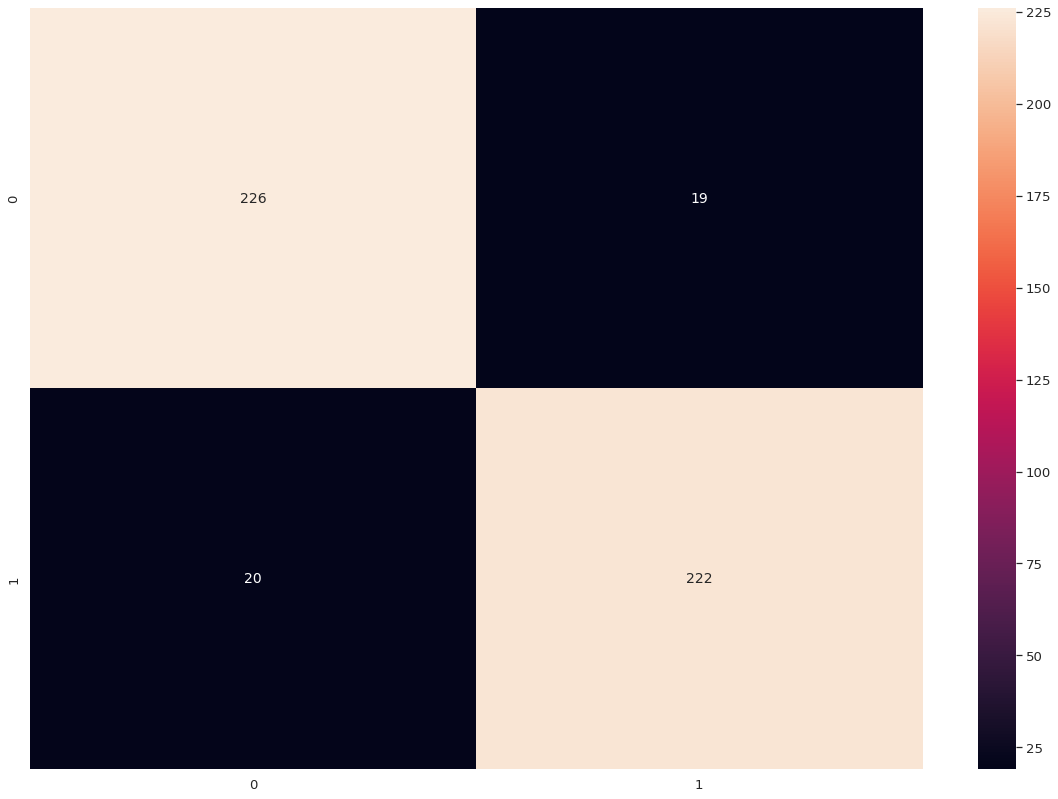

In [92]:
import seaborn as sn
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, range(2), range(2))
plt.figure(figsize=(20,14))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='g') # for num predict size

plt.show()

In [93]:
label_dict = output_tokenizer.word_index

In [94]:
label = [key for key, value in label_dict.items()]

In [95]:
print(classification_report(y_true, predicted_classes, target_names=label, digits=4))

              precision    recall  f1-score   support

         neg     0.9187    0.9224    0.9206       245
         pos     0.9212    0.9174    0.9193       242

    accuracy                         0.9199       487
   macro avg     0.9199    0.9199    0.9199       487
weighted avg     0.9199    0.9199    0.9199       487



**LSTM model**

Prepare test data

In [96]:
test_df.head()

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class,clean_comments
2748,สแกนใบหน้าไม่ดีระบบควรปรับปรุง,1.0,0.0,11.9.1,2022-11-04 06:45:23,neg,สแกน ใบหน้า ดี ระบบ ปรับปรุง
2694,ใช้งานสะดวกสบาย,5.0,0.0,11.9.1,2022-11-06 17:08:55,pos,ใช้งาน สะดวกสบาย
1931,แย่มาก​ ปรับปรุงไห้ทัน​ค่ายอื่นด้วยค่ะ​,1.0,0.0,0.0.0,2022-10-22 13:27:32,neg,แย่มาก ​ ปรับปรุง ให้ ​ ค่าย ​
1575,ปิดปรับปรุงบ่อยมากคะแข้ไขั,3.0,0.0,0.0.0,2022-11-09 10:37:38,neg,ปรับปรุง แข้ ไข ั
1934,โหลดไม่ได้,5.0,0.0,3.59.0,2022-10-22 10:12:28,neg,โหลด


In [97]:
test_cleaned_words = test_df['clean_comments'].to_list()

In [98]:
test_word_tokenizer = create_tokenizer(test_cleaned_words)

In [99]:
test_encoded_doc = encoding_doc(test_word_tokenizer, test_cleaned_words)

In [100]:
test_padded_doc = padding_doc(test_encoded_doc, max_length)
print("Shape of padded docs = ",test_padded_doc.shape)

print(test_cleaned_words[0])
print(test_encoded_doc[0])
print(test_padded_doc[0])

Shape of padded docs =  (609, 132)
สแกน ใบหน้า ดี ระบบ ปรับปรุง
[39, 47, 2, 12, 18]
[39 47  2 12 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]


In [101]:
test_category = test_df['class'].to_list()

In [102]:
test_unique_category = list(set(test_category))
test_unique_category

['neg', 'pos']

In [103]:
test_output_tokenizer = create_tokenizer(test_unique_category)

In [104]:
test_encoded_output = encoding_doc(test_output_tokenizer, test_category)
print(test_category[1:2])
print(test_encoded_output[1:2])

['pos']
[[2]]


In [105]:
test_encoded_output = np.array(test_encoded_output).reshape(len(test_encoded_output), 1)
test_encoded_output.shape

(609, 1)

In [106]:
test_output_one_hot = one_hot(test_encoded_output)
print(test_encoded_output[0])
print(test_output_one_hot[0])

[1]
[1. 0.]


In [107]:
test_padded_doc

array([[ 39,  47,   2, ...,   0,   0,   0],
       [  9,  61,   0, ...,   0,   0,   0],
       [ 13,  19,  18, ...,   0,   0,   0],
       ...,
       [883,  27,  26, ...,   0,   0,   0],
       [  3,  18, 212, ...,   0,   0,   0],
       [199, 310, 885, ...,   0,   0,   0]], dtype=int32)

In [108]:
predicted_classes = np.argmax(predict_model.predict(test_padded_doc), axis=-1)

20/20 [==============================] - 0s 9ms/step


In [109]:
predicted_classes

array([1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,

In [110]:
def mapClassLabel(n):
    mapClassList = []
    for classVal in n:
      if (classVal == 0):
        mapClassList.append("neg")
      elif (classVal == 1):
        mapClassList.append("pos")
    return mapClassList   

In [111]:
cate_predicted_classes = mapClassLabel(predicted_classes)

Add prediction value to new column

In [112]:
test_df["predict_class"] = np.array(cate_predicted_classes)

test_df.head()

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class,clean_comments,predict_class
2748,สแกนใบหน้าไม่ดีระบบควรปรับปรุง,1.0,0.0,11.9.1,2022-11-04 06:45:23,neg,สแกน ใบหน้า ดี ระบบ ปรับปรุง,pos
2694,ใช้งานสะดวกสบาย,5.0,0.0,11.9.1,2022-11-06 17:08:55,pos,ใช้งาน สะดวกสบาย,neg
1931,แย่มาก​ ปรับปรุงไห้ทัน​ค่ายอื่นด้วยค่ะ​,1.0,0.0,0.0.0,2022-10-22 13:27:32,neg,แย่มาก ​ ปรับปรุง ให้ ​ ค่าย ​,neg
1575,ปิดปรับปรุงบ่อยมากคะแข้ไขั,3.0,0.0,0.0.0,2022-11-09 10:37:38,neg,ปรับปรุง แข้ ไข ั,neg
1934,โหลดไม่ได้,5.0,0.0,3.59.0,2022-10-22 10:12:28,neg,โหลด,pos


In [113]:
y_true = np.argmax(test_output_one_hot,axis = 1)
print(test_output_one_hot[0])
print(y_true[0])

[1. 0.]
0


In [114]:
cm_lstm = confusion_matrix(y_true, predicted_classes)
np.savetxt("confusion_matrix_LSTM.csv", cm_lstm, delimiter=",")

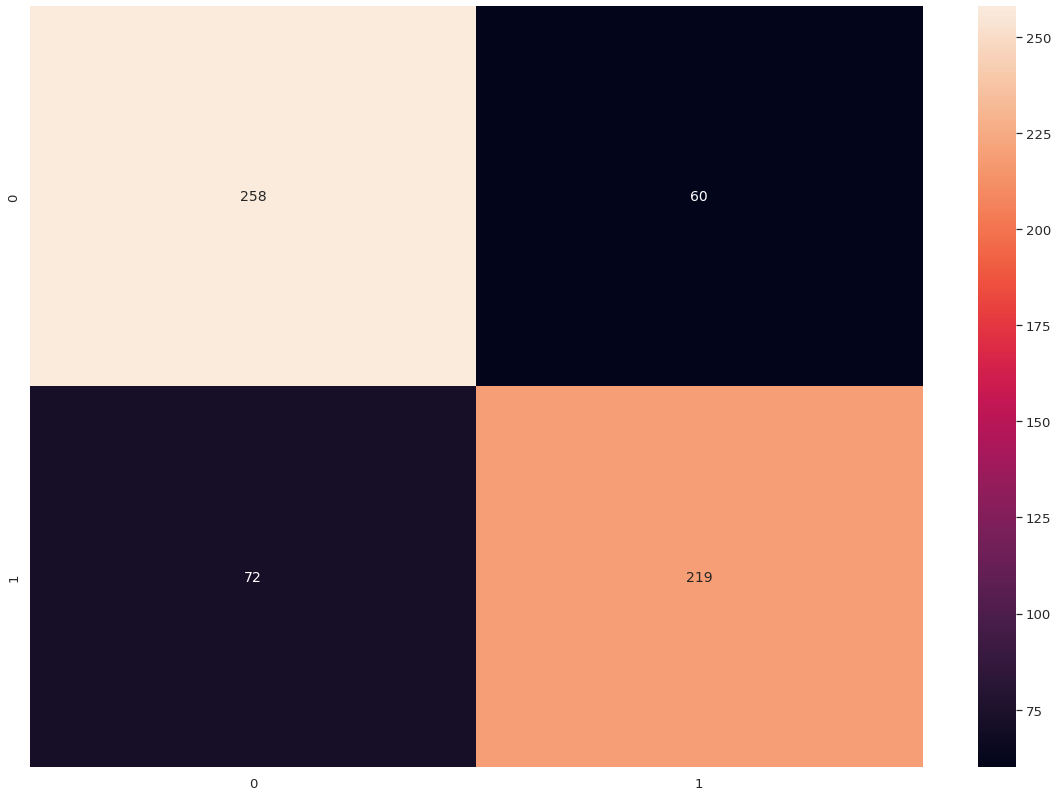

In [115]:
test_df_cm_cnn = pd.DataFrame(cm_lstm, range(2), range(2))
plt.figure(figsize=(20,14))
sn.set(font_scale=1.2) # for label size
sn.heatmap(test_df_cm_cnn, annot=True, annot_kws={"size": 14}, fmt='g') # for num predict size

plt.show()

In [116]:
label_test_dict = test_output_tokenizer.word_index

In [117]:
label_test = [key for key, value in label_test_dict.items()]

In [118]:
print(classification_report(y_true, predicted_classes, target_names=label_test, digits=4))

              precision    recall  f1-score   support

         neg     0.7818    0.8113    0.7963       318
         pos     0.7849    0.7526    0.7684       291

    accuracy                         0.7833       609
   macro avg     0.7834    0.7819    0.7824       609
weighted avg     0.7833    0.7833    0.7830       609



Predict label compare with actual comment score

In [119]:
len(test_df)

609

In [120]:
query = test_df.query("`score` >= 3 and `predict_class` == 'pos'")

len(query)

231

In [121]:
query.sample(20)

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class,clean_comments,predict_class
1647,ดีมากครับ,5.0,0.0,3.60.0,2022-11-04 12:07:52,pos,ดีมาก,pos
878,ทำไมโหลดมาแล้วเข้าใช้งานยากจังเมื่อก่อนไม่เห็น...,3.0,0.0,5.7.7,2022-10-26 04:45:23,neg,โหลด ใช้งาน แบบนี้,pos
2030,ดีมาก,5.0,0.0,0.0.0,2022-10-18 02:04:08,pos,ดีมาก,pos
1400,หลังๆมานี้ช้ามากค่ะ,5.0,0.0,5.16.0,2022-10-15 02:27:32,neg,,pos
2330,ดีครับผมใช้มาหลายปี,4.0,0.0,3.59.0,2022-10-07 08:35:39,pos,ดี ครับผม ปี,pos
139,ดีๆๆๆๆๆ,5.0,0.0,5.16.3,2022-11-09 20:53:51,pos,ดี ๆๆๆๆๆ,pos
167,ดี,5.0,0.0,5.16.1,2022-11-09 09:10:40,pos,ดี,pos
1150,ดีคะ,5.0,0.0,5.16.1,2022-10-19 11:21:23,pos,ดี,pos
1324,ดีมากๆๆ,5.0,0.0,5.16.0,2022-10-16 20:12:25,pos,ดีมาก ๆๆ,pos
3003,ดีมากครับ🕸️☺,5.0,0.0,10.13.1,2022-10-26 00:42:22,pos,ดีมาก 🕸️☺,pos


In [122]:
query = test_df.query("`score` < 3 and `predict_class` == 'neg'")

len(query)

197

In [123]:
query.sample(20)

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class,clean_comments,predict_class
3050,เเล้วมาล่มถูกเวลาด้วยนะคนจำเป็นๆ ไม่บอกล่วงหน้...,1.0,0.0,0.0.0,2022-10-25 08:42:09,neg,เเล้ว ล่ม เวลา คน ล่วงหน้า,neg
3097,ยิ่งใช้ยิ่งแย่,1.0,0.0,11.9.1,2022-10-25 07:43:58,neg,แย่,neg
209,ใช้งานช้ามากเงียบบางทีก็ค้าง,1.0,0.0,5.16.3,2022-11-08 13:39:29,neg,ใช้งาน เงียบ ค้าง,neg
3344,กากอีสัส โอนตัวเข้ามาแล้ว ตังไม่ขึ้น อย่างกาก ...,1.0,0.0,11.9.1,2022-10-18 07:20:23,neg,กาก อี สัส โอน ตัว เข้ามา ตัง กาก กาก ...,neg
1325,เด้งออกบ่อยมาก หลังมากเข้าใช้งานยากมาก ปรับปรุ...,1.0,1.0,5.16.1,2022-10-16 18:45:55,neg,เด้ง ใช้งาน ปรับปรุง ก็ งั้น,neg
2431,ธนาคารที่ห่วยแตกที่สุดแล้ว ล้มตลอด ใช่ธนาคารอื...,1.0,0.0,3.58.0,2022-10-03 18:42:26,neg,ธนาคาร ห่วยแตก ล้ม ธนาคาร ห่วย ธนาคาร ระ...,neg
2994,ทำมั้ยตอนนี้เติมช็อปปี้เพไม่ได้คะ ที่ผ่านเต็มไ...,1.0,0.0,11.9.1,2022-10-26 03:54:50,neg,ทำ ตอนนี้ เติม ช็อป ปี้ เพ เต็ม เ เก้ ไข ด...,neg
1165,ห่วยแตก มีข้อมูลแล้วจะล็อกอินเด้งให้กูสมัครใหม...,1.0,0.0,5.16.1,2022-10-19 05:32:21,neg,ห่วยแตก ข้อมูล แล้ วจะ ล็อกอิน เด้ง สมัคร,neg
2291,อัปเดตไม่ได้เลย,1.0,0.0,3.54.0,2022-10-08 01:38:48,neg,อัปเดต,neg
1296,แอพเข้าใช้งานไม่ได้เลยแย่มากๆๆๆ,1.0,0.0,0.0.0,2022-10-17 07:40:23,neg,แอปพลิเคชัน ใช้งาน แย่มาก ๆๆๆ,neg


In [124]:
query = test_df.query("`score` >= 3 and `predict_class` != 'pos'")

len(query)

133

In [125]:
query.sample(20)

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class,clean_comments,predict_class
62,แย่นะใช้แล้วสะดุดมากพาให้แอพอื่นสะดุดไปด้วยควร...,3.0,0.0,5.16.3,2022-11-11 07:21:15,neg,แย่ ใช้แล้ว สะดุด แอปพลิเคชัน สะดุด ปรับปรุง /...,neg
407,ดีเยี่ยม,5.0,0.0,5.16.1,2022-11-05 08:10:48,pos,ดีเยี่ยม,neg
2528,โอนไม่ได้,4.0,0.0,0.0.0,2022-09-30 11:43:14,neg,โอน,neg
341,แอปเคพลัสมีปัญหาบ่อยมากพอกดเข้าไปก็จะขึ้นว่าหย...,5.0,1.0,5.16.1,2022-11-06 04:59:09,neg,แอปพลิเคชัน เคพลัส มีปัญหา กด เข้าไป หยุด ทำงาน,neg
1029,ดีงับแค่เวลาสมัครในแอปใช้เวลานิดนึงงับ,5.0,0.0,5.16.1,2022-10-22 03:52:38,neg,ดี งับ เวลา สมัคร แอปพลิเคชัน ใช้เวลา นิดนึง งับ,neg
123,ชอบ,4.0,0.0,5.16.1,2022-11-10 05:13:36,pos,ชอบ,neg
322,เปลี่ยนโทรศัพท์ใหม่แล้วเข้าแอปไม่ได้เป็นเพราะอ...,5.0,0.0,5.16.2,2022-11-06 08:18:42,neg,โทรศัพท์ แอปพลิเคชัน เพราะอะไร ?,neg
2104,เวลาupdateทำไมช้ามาก,3.0,0.0,3.54.0,2022-10-14 11:46:51,neg,เวลา update,neg
939,ปัญหาคือเวลาเปลี่ยนเครื่องใหม่ แม่งต้องใช้เน็ต...,3.0,6.0,5.16.1,2022-10-24 15:10:15,neg,ปัญหา เวลา เครื่อง แม่ ง เน็ต ซิม ผูก แบ้ ง ...,neg
2071,very good,5.0,0.0,3.59.0,2022-10-16 15:52:42,pos,good,neg


In [126]:
query = test_df.query("`score` < 3 and `predict_class` != 'neg'")

len(query)

48

In [127]:
query.sample(20)

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class,clean_comments,predict_class
1199,ระบบแย่มาก,1.0,0.0,5.16.1,2022-10-18 14:02:22,neg,ระบบ แย่มาก,pos
1059,เป็นอะไรครับวันนี้เข้าใช้งานไม่ได้เลยครับ,1.0,0.0,5.16.1,2022-10-21 10:59:20,neg,ใช้งาน,pos
680,เข้าระบบได้ช้ามากๆๆๆ ระบบแอพแย่มาก จนคิดอยากเป...,2.0,0.0,5.15.10,2022-10-31 01:40:24,neg,ระบบ ๆๆๆ ระบบ แอปพลิเคชัน แย่มาก ธนาคาร ...,pos
285,ระบบแย่นะคับ,1.0,0.0,0.0.0,2022-11-07 00:43:49,neg,ระบบ แย่ คับ,pos
343,ดีมากแต่ว่าตอนนี้ทำไมถึงเข้าแอปไม่ได้ไม่รุ้ครับ,1.0,0.0,5.16.2,2022-11-06 03:47:01,neg,ดีมาก ตอนนี้ แอปพลิเคชัน รุ้,pos
2780,ทำไมธนาคารไม่อัปเดตยอด,1.0,0.0,11.9.1,2022-11-02 20:08:17,neg,ธนาคาร อัปเดต ยอด,pos
728,ดีค่ะ,1.0,0.0,5.16.1,2022-10-30 01:08:57,pos,ดี,pos
3398,แสกนหน้าไม่ผ่านเลย. ต้องทำยังไง มีแต่ต้องไปธนา...,1.0,0.0,11.9.1,2022-10-16 11:27:42,neg,แส กน หน้า ทำ ธนาคาร หรอ,pos
2314,หลุดบ่อย,1.0,0.0,3.59.0,2022-10-07 18:57:12,neg,หลุด,pos
3062,ไม่ค่อยดีช้า แถมเวลาระบบมีปัญหาไม่ค่อยแจ้งเตือ...,2.0,8.0,11.9.1,2022-10-25 08:24:54,neg,ดี แถม เวลา ระบบ มีปัญหา แจ้ง เตือน คน รีบ โ...,pos


Predict label compare with actual label

In [128]:
query = test_df.query("`class` == 'pos' and `predict_class` == 'pos'")

len(query)

219

In [129]:
query.sample(20)

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class,clean_comments,predict_class
2630,ใช้ดีมากๆค่ะ,5.0,0.0,0.0.0,2022-11-09 14:45:04,pos,ดีมาก,pos
3389,ใช้งานสบาย,5.0,0.0,0.0.0,2022-10-16 17:48:15,pos,ใช้งาน,pos
2330,ดีครับผมใช้มาหลายปี,4.0,0.0,3.59.0,2022-10-07 08:35:39,pos,ดี ครับผม ปี,pos
332,ดีมาก,5.0,0.0,5.15.6,2022-11-06 06:47:17,pos,ดีมาก,pos
967,ดี,5.0,0.0,5.16.1,2022-10-23 22:36:15,pos,ดี,pos
1877,ดี,5.0,1.0,3.60.0,2022-10-25 06:03:58,pos,ดี,pos
60,ดีมากครับ,3.0,0.0,5.16.3,2022-11-11 07:36:04,pos,ดีมาก,pos
552,ดี,5.0,0.0,5.16.1,2022-11-02 18:34:08,pos,ดี,pos
2650,ดี,5.0,0.0,11.9.1,2022-11-09 02:43:31,pos,ดี,pos
1018,",,😀😀",4.0,0.0,5.16.1,2022-10-22 09:33:24,pos,😀😀,pos


In [130]:
query = test_df.query("`class` == 'neg' and `predict_class` == 'neg'")

len(query)

258

In [131]:
query.sample(20)

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class,clean_comments,predict_class
2831,แอปแย่มาก อยู่​ดีๆก็เข้าไม่ได้,1.0,0.0,0.0.0,2022-11-01 04:17:58,neg,แอปพลิเคชัน แย่มาก ​ ดี,neg
2334,เเอปทำเชี้ยอะไร วันศุกร์ที่ไรเเมร่งมีปัณหาตลอด...,1.0,5.0,3.59.0,2022-10-07 05:33:23,neg,เ เอ ป ทำ เชี้ย ศุกร์ เ เม ร่ง ปัณ หา ถาม ...,neg
185,ช่วงนี้แอปเด้งบ่อยมาก เด้งเข้าไปในแอพอื่นๆตลอด...,2.0,0.0,5.16.1,2022-11-09 03:46:31,neg,แอปพลิเคชัน เด้ง เด้ง เข้าไป แอปพลิเคชัน เ...,neg
2394,แอพชอบล้มเวลาจำเป้นฝนตกนี้ยิ่งเป้นบ่อยโอนตังไม...,1.0,0.0,3.59.0,2022-10-05 04:05:08,neg,แอปพลิเคชัน ชอบ ล้ม เวลา เป็น ฝนตก เป็น โอน ตัง,neg
1742,การแจ้งเตือนเงินเข้าไม่ดีเลย,2.0,0.0,3.58.0,2022-10-31 14:51:37,neg,แจ้ง เตือน เงิน ดี,neg
214,เปิดใน Line ปี2564,3.0,0.0,5.16.1,2022-11-08 12:18:48,neg,line ปี 2564,neg
1714,อัพเดตใหม่แล้วไม่ต้องสแกนลายนิ้วมือไม่ต้องใส่ร...,1.0,20.0,3.60.0,2022-11-01 12:17:54,neg,อัปเดต ไม่ต้อง สแกน ลายนิ้วมือ ไม่ต้อง ใส่รหัส...,neg
2544,ระบบล่ม หรือทำธุรกรรมไม่ได้น่าจะแจ้งไว้สักหน่อ...,1.0,2.0,3.59.0,2022-09-30 07:28:31,neg,ระบบ ล่ม ทำ ธุรกรรม จะแจ้ง สักหน่อย คับ ดูแล...,neg
2857,ทำรายการโอนซ้ำไม่ได้แย่มากต้องเอาเลขบัญชีมาใส่...,1.0,0.0,11.9.1,2022-10-31 06:51:09,neg,ทำ รายการ โอน ซ้ำ แย่มาก เลข บัญชี ใส่,neg
433,อัปเดตแอฟแล้วเข้าแอฟไม่ได้เลย,3.0,0.0,5.16.2,2022-11-05 03:03:12,neg,อัปเดต แอปพลิเคชัน แอปพลิเคชัน,neg


In [132]:
query = test_df.query("`class` == 'pos' and `predict_class` != 'pos'")

len(query)

72

In [133]:
query.sample(20)

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class,clean_comments,predict_class
3212,Good,5.0,0.0,11.9.1,2022-10-21 07:18:24,pos,good,neg
1711,ขอบคุณทำให้ลูกค้าผู้รับบริการได้รับความสะดวกแล...,4.0,0.0,3.60.0,2022-11-01 13:36:30,pos,ขอบคุณ ลูกค้า ผู้รับ บริการ ความสะดวก ปลอดภัย ...,neg
1022,ดีเยี่ยมมากเลยคับสะดวกสบายขึ้นเยอะเลย,5.0,0.0,5.16.1,2022-10-22 07:57:23,pos,ดีเยี่ยม คับ สะดวกสบาย,neg
3132,ก็โอเคร แต่ต้องการยกเลิกพร้อมเพย์ทำไม่ได้อ่ะ..,3.0,0.0,11.9.1,2022-10-24 23:46:18,pos,โอเค ร ต้องการ ยกเลิก เพ ย์ ทำ อ่ะ,neg
407,ดีเยี่ยม,5.0,0.0,5.16.1,2022-11-05 08:10:48,pos,ดีเยี่ยม,neg
2719,ชอบค่ะ เข้าใจง่าย,5.0,0.0,11.9.1,2022-11-05 09:26:44,pos,ชอบ เข้าใจง่าย,neg
871,ชอบมาก,5.0,0.0,5.16.1,2022-10-26 08:49:49,pos,ชอบ,neg
2464,เยี่ยม,5.0,0.0,3.59.0,2022-10-03 01:01:03,pos,เยี่ยม,neg
1773,เป็น app ที่ใช้งานง่ายสะดวกสบายไม่ต้องไปโอนที่...,5.0,1.0,3.60.0,2022-10-30 12:11:37,pos,app ใช้งาน สะดวกสบาย ไม่ต้อง โอน ธนาคาร,neg
2743,เยี่ยม,5.0,0.0,11.9.1,2022-11-04 11:02:13,pos,เยี่ยม,neg


In [134]:
query = test_df.query("`class` == 'neg' and `predict_class` != 'neg'")

len(query)

60

In [135]:
query.sample(20)

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class,clean_comments,predict_class
1550,อัพเดตใหม่ แคปหน้าจอไม่ได้ ไม่okเลย,1.0,0.0,3.60.0,2022-11-11 01:59:49,neg,อัปเดต แคป หน้าจอ ok,pos
111,คียต่สเดิม้ตอบฃต์,5.0,0.0,5.16.3,2022-11-10 09:09:49,neg,คียต่ส เดิม ้ ตอบ ฃต์,pos
2986,ปัญหาเยอะชิบหายไอสัส,1.0,1.0,0.0.0,2022-10-26 05:55:15,neg,ปัญหา ชิบหาย ไอ สัส,pos
1926,มีปัญญาบ่อยชิป,1.0,0.0,3.60.0,2022-10-22 18:03:06,neg,ปัญญา ชิป,pos
285,ระบบแย่นะคับ,1.0,0.0,0.0.0,2022-11-07 00:43:49,neg,ระบบ แย่ คับ,pos
942,เข้าระบบไม่ได้คะ ปรับปรุงด้วยคะ หลังๆแอปช้ามาก,1.0,0.0,0.0.0,2022-10-24 14:00:29,neg,ระบบ ปรับปรุง แอปพลิเคชัน,pos
1353,ระบบไม่ค่อยเสถียรเลยช่วงหลังๆ,2.0,0.0,5.16.1,2022-10-16 07:01:35,neg,ระบบ เสถียร,pos
343,ดีมากแต่ว่าตอนนี้ทำไมถึงเข้าแอปไม่ได้ไม่รุ้ครับ,1.0,0.0,5.16.2,2022-11-06 03:47:01,neg,ดีมาก ตอนนี้ แอปพลิเคชัน รุ้,pos
1504,โอเค,5.0,0.0,3.60.0,2022-11-12 12:59:54,neg,โอเค,pos
288,เงินในระบบธนาคารช้ามาก,5.0,0.0,5.16.1,2022-11-06 23:30:48,neg,เงิน ระบบ ธนาคาร,pos


Word cloud - positive comment

In [136]:
query_pos = test_df.query("`class` == 'pos' and `predict_class` == 'pos'")

from wordcloud import WordCloud
text = " ".join(i for i in test_df.clean_comments)
stop_words = ["ดีมาก", "ดี", "ห่วย","ห่วยแตก","โคตรห่วย","แย่มาก","แย่","แย่จัง","กาก","ล่ม","ระบบล่ม","ปรับปรุง",
              "แอพพลิเคชันล่ม","แอปพลิเคชันล่ม","แอปพลิเคชันมีปัญหา","แอปพลิเคชันแย่มาก","แอปพลิเคชันเด้ง","ยุ่งยาก",
              "ลบติดตั้งใหม่","ล้ม","ใช้ไม่ได้","มีปัญหา","เด้ง","เสียเวลา","อัปเดตห่วย","ดีคับ","ok",
              "เยี่ยม","ดีมากคับ","app","แอปพลิเคชัน"] + th_stop_words
regexp = r"[ก-๙a-zA-Z']+"
wordcloud = WordCloud(
                      font_path="/content/THSarabunNew.ttf", 
                      relative_scaling = 0.3,
                      min_font_size=1,
                      background_color="white",
                      width=1024,
                      height=768,
                      max_words=2000, 
                      #mask=mask,
                      colormap='plasma', 
                      scale=3,
                      font_step=4,
                      contour_width=3, 
                      contour_color='steelblue', 
                      collocations=False,
                      regexp=regexp,
                      margin=2,
                      stopwords = stop_words
                      ).generate(text)

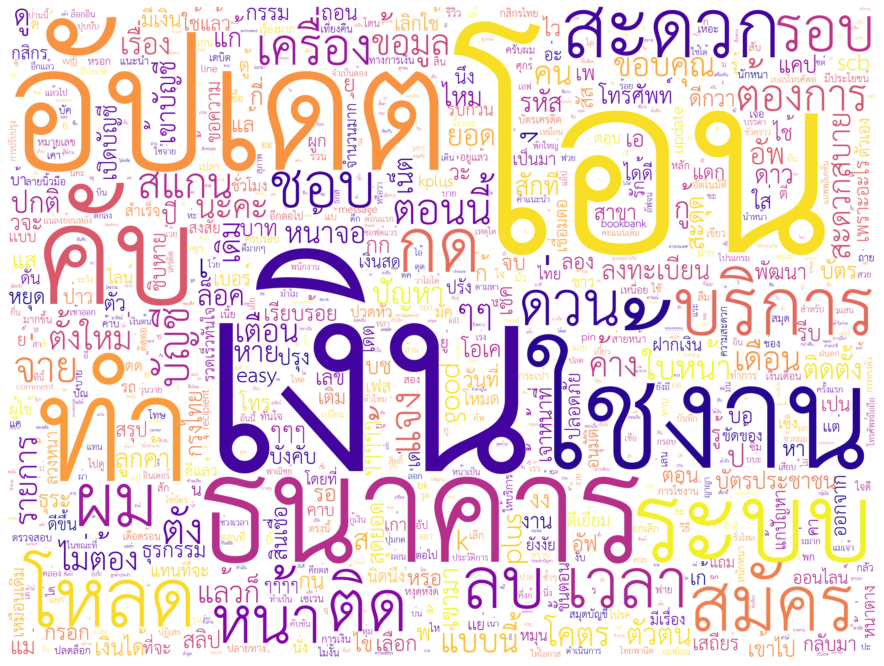

In [137]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
fig.show()

In [138]:
print(wordcloud.words_.keys())

dict_keys(['เงิน', 'โอน', 'อัปเดต', 'ธนาคาร', 'ทำ', 'ใช้งาน', 'คับ', 'ระบบ', 'สะดวก', 'โหลด', 'บริการ', 'สมัคร', 'กด', 'ผม', 'ติด', 'ลบ', 'เวลา', 'หน้า', 'ชอบ', 'ด่วน', 'รอบ', 'เครื่อง', 'ต้องการ', 'สแกน', 'ตอนนี้', 'บัญชี', 'จ่าย', 'ตัง', 'แจ้ง', 'ข้อมูล', 'ค้าง', 'ใบหน้า', 'แบบนี้', 'ขอบคุณ', 'เ', 'นะคะ', 'โคตร', 'คน', 'เดือน', 'ตั้งใหม่', 'เตือน', 'ไม่ต้อง', 'ๆๆ', 'สะดวกสบาย', 'ง', 'รายการ', 'อัพ', 'ยอด', 'แล้วก็', 'ป', 'ปัญหา', 'เดิม', 'เรื่อง', 'กู้', 'ตัวตน', 'ดู', 'หน้าจอ', 'good', 'k', 'plus', 'หาย', 'ปกติ', 'ส', 'ติดตั้ง', 'ล็อค', 'ลงทะเบียน', 'เข้ามา', 'เข้าบัญชี', 'ดาว', 'รหัส', 'ลูกค้า', 'ไหม', 'แก้', 'เน็ต', 'สักที', 'ปี', 'กี่', 'งง', 'สะดุด', 'บัตรประชาชน', 'เงินได้', 'โทรศัพท์', 'พ', 'รีบ', 'รอ', 'บัตร', 'กก', 'scb', 'เปิดบัญชี', 'สุดยอด', 'ดีกว่า', 'กรุงไทย', 'ธุระ', 'แม่', 'บช', 'แคป', 'โอเค', 'แส', 'กน', 'ก้', 'บาท', 'ยุ', 'เอ', 'สลิป', 'ไข', 'ๆๆๆ', 'รู้', 'หยุด', 'ว่ะ', 'กรอก', 'เลข', 'บอ', 'เรียบร้อย', 'อัฟ', 'ตัว', 'ถอน', 'เข้าไป', 'จบ', 'วันที่', 'ใส่', 'งาน', 'ธ

Word cloud - negative comment

In [139]:
query_neg = test_df.query("`class` == 'neg' and `predict_class` == 'neg'")


text = " ".join(i for i in test_df.clean_comments)
stop_words = ["ดีมากคับ","ดี","ดีมาก","ดีคับ","เยี่ยม","แย่มาก","แย่่","Good","ok","ห่วย","ห่วยแตก","ได้ดี","ชอบ","app","แอปพลิเคชัน"] + th_stop_words
regexp = r"[ก-๙a-zA-Z']+"
wordcloud = WordCloud(
                      font_path="/content/THSarabunNew.ttf", 
                      relative_scaling = 0.3,
                      min_font_size=1,
                      background_color="white",
                      width=1024,
                      height=768,
                      max_words=2000, 
                      #mask=mask,
                      colormap='plasma', 
                      scale=3,
                      font_step=4,
                      contour_width=3, 
                      contour_color='steelblue', 
                      collocations=False,
                      regexp=regexp,
                      margin=2,
                      stopwords = stop_words
                      ).generate(text)

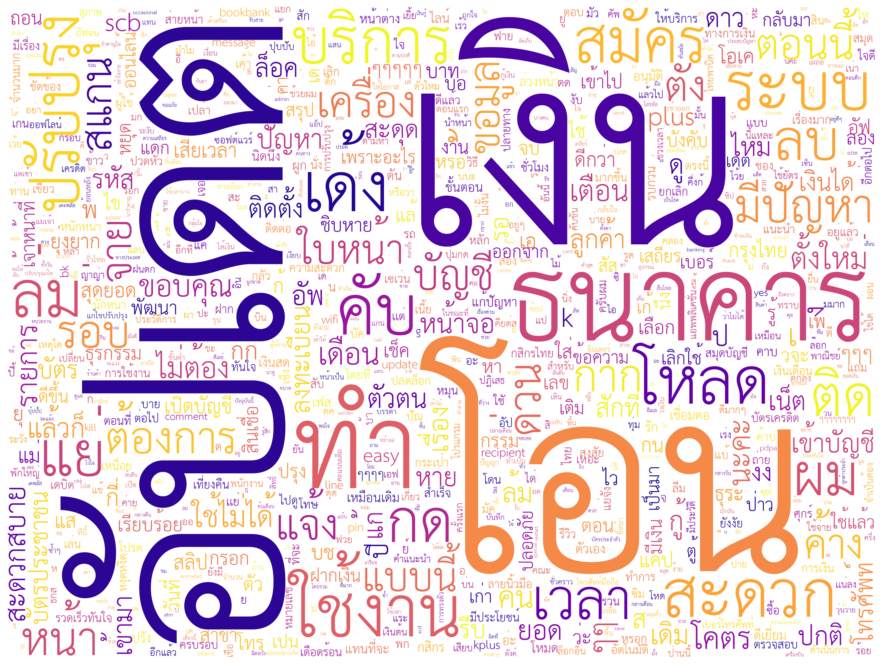

In [140]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
fig.show()

In [141]:
print(wordcloud.words_.keys())

dict_keys(['เงิน', 'โอน', 'อัปเดต', 'ธนาคาร', 'ทำ', 'ใช้งาน', 'คับ', 'เด้ง', 'ระบบ', 'สะดวก', 'โหลด', 'ล่ม', 'บริการ', 'ปรับปรุง', 'แย่', 'สมัคร', 'กด', 'ผม', 'ติด', 'ลบ', 'เวลา', 'มีปัญหา', 'หน้า', 'ด่วน', 'กาก', 'รอบ', 'เครื่อง', 'ต้องการ', 'สแกน', 'ตอนนี้', 'บัญชี', 'จ่าย', 'ตัง', 'แจ้ง', 'ข้อมูล', 'ค้าง', 'ใบหน้า', 'แบบนี้', 'ขอบคุณ', 'เ', 'นะคะ', 'โคตร', 'คน', 'เดือน', 'ตั้งใหม่', 'ใช้ไม่ได้', 'เตือน', 'ไม่ต้อง', 'ๆๆ', 'สะดวกสบาย', 'ง', 'รายการ', 'อัพ', 'ยอด', 'แล้วก็', 'ป', 'ปัญหา', 'ล้ม', 'เดิม', 'เรื่อง', 'กู้', 'ตัวตน', 'ดู', 'หน้าจอ', 'k', 'plus', 'หาย', 'ปกติ', 'ส', 'ติดตั้ง', 'ล็อค', 'ลงทะเบียน', 'เข้ามา', 'เข้าบัญชี', 'ดาว', 'รหัส', 'ลูกค้า', 'ไหม', 'แก้', 'เน็ต', 'สักที', 'ปี', 'กี่', 'งง', 'สะดุด', 'บัตรประชาชน', 'เงินได้', 'โทรศัพท์', 'พ', 'รีบ', 'รอ', 'บัตร', 'กก', 'scb', 'เปิดบัญชี', 'เสียเวลา', 'สุดยอด', 'ยุ่งยาก', 'ดีกว่า', 'กรุงไทย', 'ธุระ', 'แม่', 'บช', 'แคป', 'โอเค', 'แส', 'กน', 'ก้', 'บาท', 'ยุ', 'เอ', 'สลิป', 'ไข', 'ๆๆๆ', 'รู้', 'หยุด', 'ว่ะ', 'กรอก', 'เลข', 'บ